## Process and Visualize IWG data from Arctic Heat

Arctic Heat IWG files are obtained during aircraft flights.  Using python and a few standard data analysis and visualization packages, we can take a few quick looks into the data.

**Note** GMT-Python is in heavy development and may not be available unless you are on a mac or linux machine.  Alternatives are Cartopy or outputing your data into your favorite GIS software.

For more information on the analysis, contact: Shaun.Bell@noaa.gov

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import cmocean

import pandas as pd
import numpy as np

import os

from matplotlib import colors as mcolors


colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
clist = list(colors.keys())
clist[0:8]

['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

### Data Ingestion and data summary/statistics

A few lines to list and read the .iwg files into a dictionary of pandas dataframes.

The original .iwg files have headerlines everyso often through the file.  I usually clean these up by removing all of the lines and adding one iteration of headers at the top of the file and then call these files ".clean"

In [6]:
source_dir = '/Users/bell/ecoraid/2019/Additional_FieldData/ArcticHeat/IWG_data/'
source_file = [x for x in os.listdir(source_dir) if x.endswith('.clean.csv')]

In [7]:
dfs = {}
for i,filename in enumerate(source_file):
    print(filename)
    dfs.update({filename:pd.read_csv(source_dir + filename,delimiter=',',parse_dates=['TIME'],index_col='TIME')})

20190720_231146_IWG.clean.csv
20190716_170539_IWG.clean.csv
20190720_170527_IWG.clean.csv
20190717_200841_IWG.clean.csv
20190717_001212_IWG.clean.csv
20190718_231103_IWG.clean.csv
20190719_190728_IWG.clean.csv
20190719_210910_IWG.clean.csv


In [8]:
for file in dfs.keys():
    print("Summary for file:{}".format(file))
    print(dfs[file].describe())

Summary for file:20190720_231146_IWG.clean.csv
         Unnamed: 0           LAT           LON        ALTGPS           SST  \
count  10129.000000  10129.000000  10129.000000  10129.000000  10129.000000   
mean    5233.015895     68.316588   -153.614857   3066.023991      1.875318   
std     3021.607561      1.939515      1.971969    862.997176      4.986720   
min        0.000000     64.933014   -156.861069     12.000000    -20.810000   
25%     2617.000000     66.631241   -155.334976   3313.000000     -1.560000   
50%     5233.000000     68.325241   -153.453217   3355.000000      0.050000   
75%     7849.000000     70.040276   -151.869171   3393.000000      3.900000   
max    10466.000000     71.287003   -150.496658   3420.000000     18.550000   

         PYRAUCLEAR            RH  
count  10129.000000  10129.000000  
mean     491.062788     84.776947  
std      133.482480     22.980582  
min     -335.090000      6.500000  
25%      403.870000     80.100000  
50%      536.440000     9

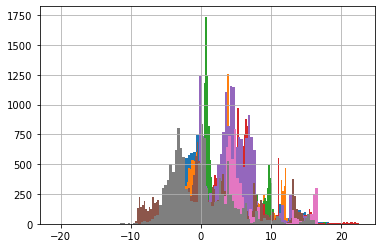

In [9]:
for file in dfs.keys():
    dfs[file]['SST'].hist(bins=100)

import in locations of ALAMO Drops as well

In [10]:
alamo_loc = pd.read_csv('../data/Summer2018_Deployments.tsv',delimiter='\t+', engine='python')

FileNotFoundError: [Errno 2] No such file or directory: '../data/Summer2018_Deployments.tsv'

In [11]:
alamo_loc

NameError: name 'alamo_loc' is not defined

### Geolocated Plots of SST/Flight Altitude using GMT-Python

After having imported and glanced at the data and statistics, lets plot the SST as a function of flight path

In [12]:
import pygmt as gmt

In [13]:
# Load the builtin Earth relief grid as an xarray.DataArray.
relief = gmt.datasets.load_earth_relief(resolution="02m")


earth_relief_02m: Download file from the GMT ftp data server [data set size is 58M].
earth_relief_02m: Earth Relief at 2x2 arc minutes provided by ETOPO2v2g_f4 [NOAA].


In [14]:
fig = gmt.Figure()

fig.grdimage(relief,region=[-175, -140, 60, 77], projection='B-155/60/55/60/6i', cmap="geo", frame=True)
fig.coast(shorelines='0.25p,black',rivers='A/0.25p,lightblue')

In [15]:
#plot each path as a color
acount=0

for file in sorted(dfs.keys())[0:5]:
    print(file)
    fig.plot(x=dfs[file].LON.values, y=dfs[file].LAT.values, 
             color='/'.join(tuple( map( lambda x: str(255*x) , colors[clist[acount]] ) )), 
             style='c0.025c')
    print('/'.join(tuple( map( lambda x: str(255*x) , colors[clist[acount]] ) )))
acount+=1

for file in sorted(dfs.keys())[5:9]:
    print(file)
    fig.plot(x=dfs[file].LON.values, y=dfs[file].LAT.values, 
             color='/'.join(tuple( map( lambda x: str(255*x) , colors[clist[acount]] ) )), 
             style='c0.025c')
    print('/'.join(tuple( map( lambda x: str(255*x) , colors[clist[acount]] ) )))
acount+=1

for file in sorted(dfs.keys())[9:]:
    print(file)
    fig.plot(x=dfs[file].LON.values, y=dfs[file].LAT.values, 
             color='/'.join(tuple( map( lambda x: str(255*x) , colors[clist[acount]] ) )), 
             style='c0.025c')
    print('/'.join(tuple( map( lambda x: str(255*x) , colors[clist[acount]] ) )))
acount+=1

20190716_170539_IWG.clean.csv
0/0/255
20190717_001212_IWG.clean.csv
0/0/255
20190717_200841_IWG.clean.csv
0/0/255
20190718_231103_IWG.clean.csv
0/0/255
20190719_190728_IWG.clean.csv
0/0/255
20190719_210910_IWG.clean.csv
0/127.5/0
20190720_170527_IWG.clean.csv
0/127.5/0
20190720_231146_IWG.clean.csv
0/127.5/0


In [ ]:
#add alamo drops 'o' for arctic heat 

fig.plot(x=np.array(alamo_loc.Lon), y=np.array(alamo_loc.Lat), color='black', style='c0.125c')


In [ ]:
fig.show()

In [ ]:
fig.savefig('ARCTICHeat_Summer_Zoom.png')

In [ ]:
fig = gmt.Figure()

fig.coast(region=[-170, -140, 66, 77], projection='B-155/60/55/60/6i', land='black', water='lightgrey',
          frame=True,U=True) 

In [ ]:
#choose temp boundaries
upper_limit = 14
lower_limit = -2

for file in sorted(dfs.keys()):
    print(file)
    dfmiss = dfs[file].copy()
    dfmiss['SST'].loc[(dfs[file]['SST'] > upper_limit ) | (dfs[file]['SST'] <lower_limit)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss['SST'].apply(lambda x: (x - (lower_limit)) / (upper_limit - (lower_limit)))
    fig.plot(x=dfs[file].LON.values, y=dfs[file].LAT.values, color=256*dfnorm, cmap='thermal', style='c0.1c')


In [ ]:
fig.show()

In [ ]:
fig = gmt.Figure()

fig.coast(region=[-170, -140, 66, 77], projection='B-155/60/55/60/6i', land='black', water='lightgrey',
          frame=True,U=True) 

In [ ]:
#choose altitude boundaries
upper_alt = 500 #ft
#lower is 0ft

for file in dfs.keys():
    dfmiss = dfs[file].copy()
    dfmiss['ALTGPS'].loc[(dfs[file]['ALTGPS'] > upper_alt ) | (dfs[file]['ALTGPS'] <lower_limit)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss['ALTGPS'].apply(lambda x: (x - (0)) / (upper_alt - (0)))
    #if a cmocean colormap is used like thermal - then you need to add it to your gmt-python env
    fig.plot(x=dfs[file].LON.values, y=dfs[file].LAT.values, color=dfnorm, cmap='viridis', style='c0.1c')

fig.show()

areas greyed out above are above 500ft.  darker blue regions are lower while lighter green regions are higher

### Plotting Time vs Altitude color coded by SST

In [ ]:
for file in sorted(dfs.keys()):
    fig = plt.figure(figsize=(14, 2))
    ax1 = fig.add_subplot(111)
    plt.scatter(dfs[file].index,dfs[file]['ALTGPS'],
                s=10,c=dfs[file]['SST'],cmap=cmocean.cm.thermal,
                vmin=lower_limit,vmax=upper_limit)
    ax1.set_xlim(dfs[file].index.min(),dfs[file].index.max())
    xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
    ax1.xaxis.set_major_formatter(xfmt)
    plt.title(file)

### Color Bar Creation

Creating a consistent color bar for the thermal plots.  Maptlotlib can do this inherently but the GMT-Python package

In [ ]:
def colorbar(cmap=cmocean.cm.thermal,label=''):

    '''
    ====================
    Customized colorbars
    ====================

    This example shows how to build colorbars without an attached mappable.
    '''

    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import cmocean

    # Make a figure and axes with dimensions as desired.
    fig = plt.figure(figsize=(8, 3))
    ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

    # Set the colormap and norm to correspond to the data for which
    # the colorbar will be used.
    cmap = cmap
    norm = mpl.colors.Normalize(vmin=lower_limit, vmax=upper_limit)

    # ColorbarBase derives from ScalarMappable and puts a colorbar
    # in a specified axes, so it has everything needed for a
    # standalone colorbar.  There are many more kwargs, but the
    # following gives a basic continuous colorbar with ticks
    # and labels.
    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    cb1.set_label(label)

    # The second example illustrates the use of a ListedColormap, a
    # BoundaryNorm, and extended ends to show the "over" and "under"
    # value colors.
    cmap = mpl.colors.ListedColormap(['r', 'g', 'b', 'c'])
    cmap.set_over('0.25')
    cmap.set_under('0.75')

    plt.show()
    #plt.savefig('colorbar.jpg')

In [ ]:
colorbar(cmocean.cm.thermal,'Degrees C')
colorbar('viridis','Altitude (ft)')